In [4]:
"""
Zachary Katz
zachary_katz@mines.edu
07 November 2025

Comparison of SWOT HR backscatter with Sentinel-2 imagery over surface water on Amery Ice Shelf.
Requires RINGS 2022 Anatarctic grounding line
https://www.dropbox.com/scl/fi/386n1xlaz0jpcl46iwret/RINGS_products_2022.zip?rlkey=3izp1ptjcq4l62r3l8tswujcj&e=1&dl=0


To Do: Programatically download Sentinel-2 Data
Currently Sentinel-2 data can be downloaded from https://browser.dataspace.copernicus.eu
Search for both Sentinel-2 images we use and download
S2B_MSIL2A_20250124T035659_N0511_R118_T42DVF_20250124T065524.SAFE
S2B_MSIL2A_20250213T035659_N0511_R118_T42DVF_20250213T055814.SAFE

"""

# Imports and Extensions

import util.coordinate_transforms as transform

import numpy as np
import xarray as xr
import shapefile
import shapely

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import dask.array as da
import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from pathlib import Path
import earthaccess
import rasterio


#############################
## User-Defined Parameters ##
gl_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/' # Path to Grounding Line
S2_PATHS = [
    "/home/zkatz/Research/swot-paper/data/S2B_MSIL2A_20250124T035659_N0511_R118_T42DVF_20250124T065524.SAFE/GRANULE/L2A_T42DVF_A041185_20250124T035653/IMG_DATA/R10m",
    "/home/zkatz/Research/swot-paper/data/S2B_MSIL2A_20250213T035659_N0511_R118_T42DVF_20250213T055814.SAFE/GRANULE/L2A_T42DVF_A041471_20250213T035656/IMG_DATA/R10m",
]
## User-Defined Parameters ##
#############################

/home/zkatz/Research/DataProcessingExamples/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Download SWOT data if necessary
SWOT_PATH = "./_Data"
karin_results = earthaccess.search_data(
    short_name="SWOT_L2_HR_Raster_100m_2.0",
    temporal=("2025-01-01", "2025-03-01"),
    granule_name="SWOT_L2_HR_Raster_100m_UTM42D_N_x_x_x_*_346_143F_*.nc",
)

earthaccess.download(karin_results, SWOT_PATH, provider="POCLOUD")

# Collect SWOT data paths
rasters = list(Path(SWOT_PATH).glob("*.nc"))

QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 391.46it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:14<00:00,  7.34s/it]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 13981.01it/s]


In [ ]:
# Load Sentinel2 Data
# Following https://github.com/arjun-majumdar/Satellite_Image_Analysis/blob/main/Sentinel-2_Satellite_Image_Analysis_with_Python.ipynb

S2_imgs = []

for path in S2_PATHS:
    s2bands = list(Path(path).glob("*.jp2"))
    s2bands.sort()

    bands = []
    band_names = ["B02", "B03", "B04"]
    for i in [1, 2, 3, 4]:
        with rasterio.open(s2bands[i]) as src:
            band = da.from_array(src.read(1))
            bounds = src.bounds
            crs = src.crs
            left, bottom, right, top = (
                bounds.left,
                bounds.bottom,
                bounds.right,
                bounds.top,
            )
            ext = (left, right, bottom, top)
            bands.append(band)
            tsf = src.transform

    # Normalize bands
    for i in range(len(bands)):
        bands[i] = (bands[i] - np.min(bands[i])) / (np.max(bands[i]) - np.min(bands[i]))

    rgb = da.stack((bands[2], bands[1], bands[0]), axis=2)

    full_height, full_width = rgb.shape[:2]
    crop_y = full_height // 3
    crop_x = full_width // 3

    # Crop bottom-right two-thirds
    rgb = rgb[crop_y:, crop_x:]

    # Calculate new extents (no scaling of resolution)
    x_res = tsf.a
    y_res = -tsf.e  # pixel height is negative in geotransform

    new_left = bounds.left + crop_x * x_res
    new_top = bounds.top - crop_y * y_res
    new_right = bounds.right
    new_bottom = bounds.bottom

    ext = (new_left, new_right, new_bottom, new_top)
    rgb = rgb[::10, ::10]  # downsample by a factor of 10

    S2_imgs.append(rgb)

# Set extent for plot based on Sentinel-2 data
ext_ps71_1 = transform.utm2ps71(ext[0], ext[2], crs.to_epsg())
ext_ps71_2 = transform.utm2ps71(ext[1], ext[3], crs.to_epsg())
ext_ps71 = (ext_ps71_1[0], ext_ps71_1[1], ext_ps71_2[0], ext_ps71_2[1])
bbox = ext_ps71

In [7]:

# RINGS 2022 Grounding Line
rings_grounded_path = gl_path + 'RINGS_grounded_2022.shp'
rings_coastline_path = gl_path + 'RINGS_coastline_2022.shp'
rings_iceshelves_path = gl_path + 'RINGS_iceshelves_2022.shp'
rings_islands_ADD = gl_path + 'RINGS_islands_ADD.shp'
rings_polygonmask = gl_path + 'RINGS_polygonmask.shp'   


paths = [
    rings_coastline_path,
    rings_grounded_path,
    rings_iceshelves_path,
    rings_islands_ADD,
    rings_polygonmask,
]

records_full = []
shapes_full = []
field_names_full = []

# Load grounding line components as shapefiles
for path in paths:
    sf = shapefile.Reader(path)
    records_full.append(sf.records())
    shapes_full.append(sf.shapes())
    field_names_full.append([f[0] for f in sf.fields[1:]])

def plot_RINGS_shapefile(
    records_list: list[shapefile._Record],
    shapes_list: list[shapefile.Shape],
    field_names_list: list[str],
    ax ,
    colors: list[str],
    transform,
    fill: bool = False,
    zorder: int = 2,
    linewidth: int = 2,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
    [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for records, shapes, field_names in zip(records_list, shapes_list, field_names_list):
        for record, shape in zip(records, shapes):
            rec_dict = dict(zip(field_names, record))
            classification = rec_dict["Type"]
            points = shape.points
            parts = list(shape.parts)
            parts.append(len(points)) # Append the end index of the last part of the shapefile
            for i in range(len(parts) - 1):
                    part = points[parts[i] : parts[i + 1]]
                    if classification == "Coastline":
                        if fill:
                            ax.fill(*zip(*part), color=colors[1], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[1], linewidth=linewidth, zorder=zorder,transform=transform)
                    elif classification == "Grounded":
                        if fill:
                            ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                    elif classification == "Transient":
                        if fill:
                            ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                    elif classification == "Island":
                        if fill:
                            ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                    else:
                        pass


In [9]:
# Get Sentinel and SWOT dates
s2_date1 = S2_PATHS[0].split("/")[-5].split("_")[-1]
s2_date1 = datetime.datetime.strptime(s2_date1, "%Y%m%dT%H%M%S.SAFE")
s2_date2 = S2_PATHS[1].split("/")[-5].split("_")[-1]
s2_date2 = datetime.datetime.strptime(s2_date2, "%Y%m%dT%H%M%S.SAFE")

ds = xr.open_mfdataset(
    rasters[1], combine="nested", concat_dim="num_lines", decode_times=False
)
swot_date1 = datetime.datetime.strptime(ds.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
ds = xr.open_mfdataset(
    rasters[0], combine="nested", concat_dim="num_lines", decode_times=False
)
swot_date2 = datetime.datetime.strptime(ds.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")

print(f"SWOT Dates: {swot_date1}, {swot_date2}")
print(f"Sentinel Dates: {s2_date1}, {s2_date2}")

dates = [s2_date1, swot_date1, s2_date2, swot_date2]
dates = [date.strftime("%Y-%m-%d %H:%M:%S") for date in dates]

for i in range(len(dates)):
    if i == 0 or i == 2:
        dates[i] = "Sentinel-2: " + dates[i]
    else:
        dates[i] = "SWOT: " + dates[i]

dates

SWOT Dates: 2025-01-26 01:42:30.337416, 2025-02-15 22:27:34.512450
Sentinel Dates: 2025-01-24 06:55:24, 2025-02-13 05:58:14


['Sentinel-2: 2025-01-24 06:55:24',
 'SWOT: 2025-01-26 01:42:30',
 'Sentinel-2: 2025-02-13 05:58:14',
 'SWOT: 2025-02-15 22:27:34']

Scalebar
Colorbar
Scalebar
Colorbar


/tmp/ipykernel_76114/4268448896.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


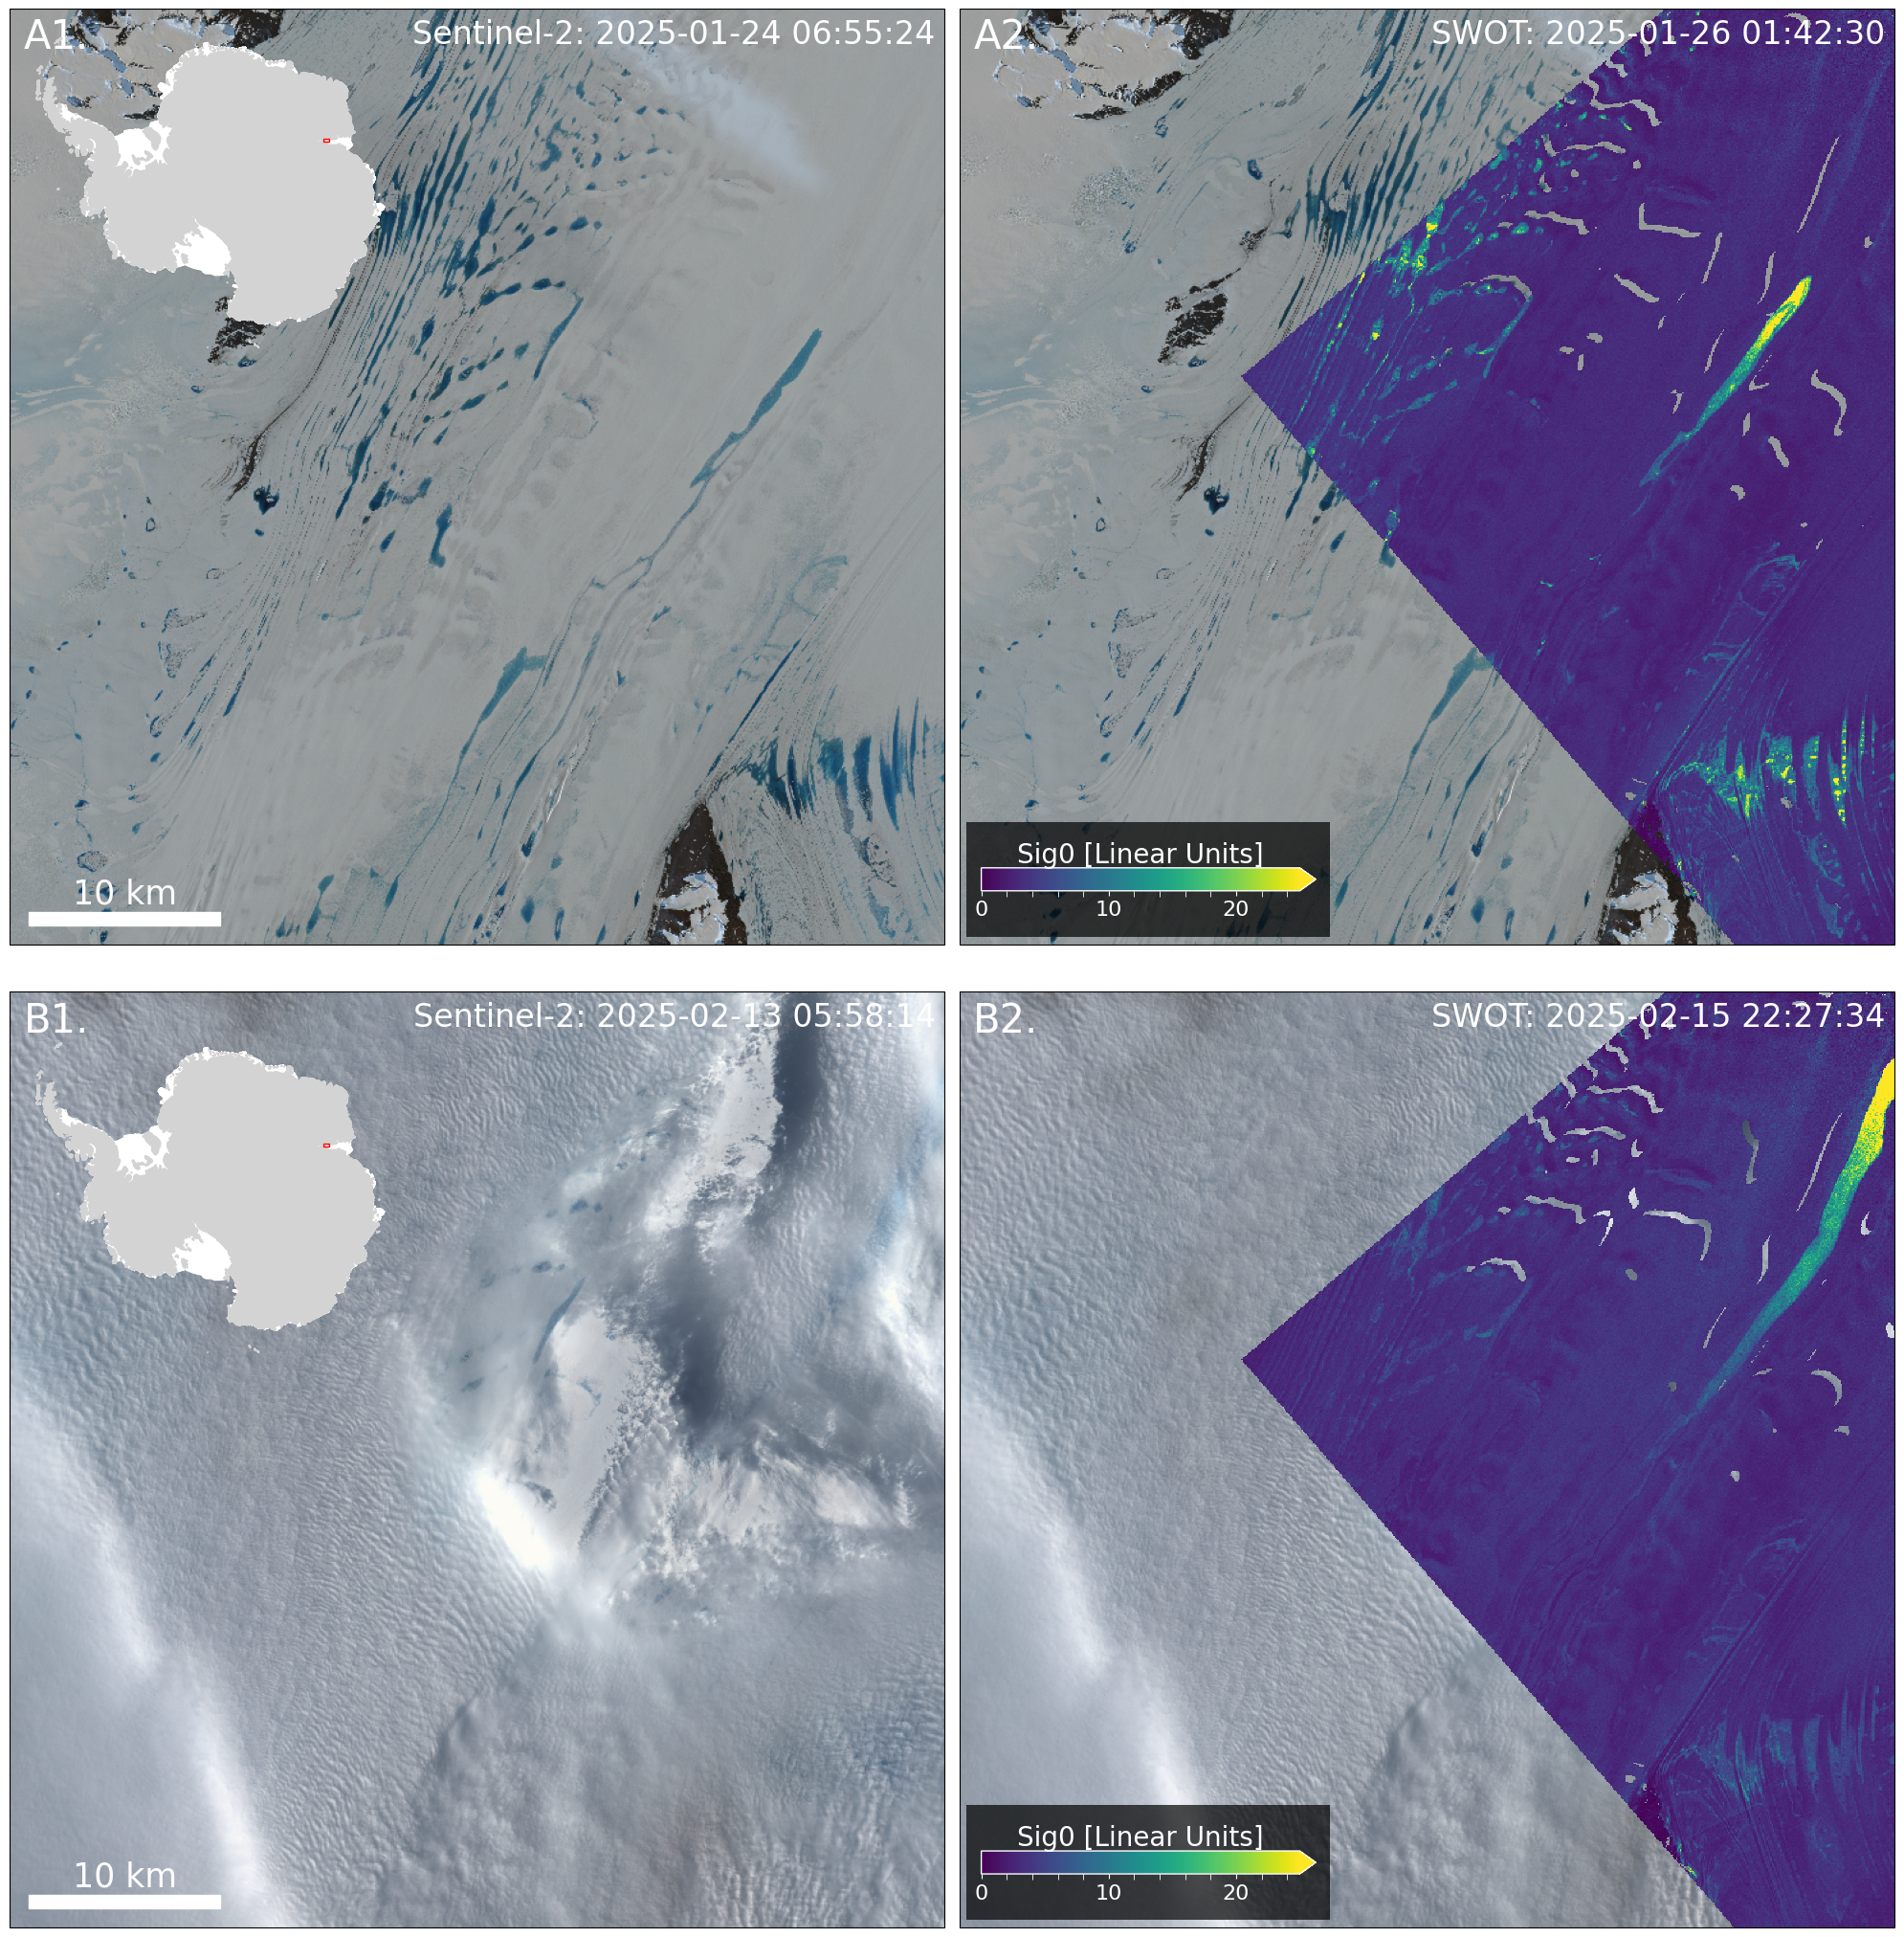

In [11]:
# Make four panel cartopy figure
cartopy_crs = ccrs.epsg(crs.to_epsg())
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
panel_labels = ["A1.", "A2.", "B1.", "B2."]
label_colors = ["white", "white", "white", "white"]
label = "Sig0 [Linear Units]"
x_size = 20
y_size = 21

fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(x_size, y_size),
    subplot_kw={"projection": cartopy_crs},
)
axs = axs.flatten()
fig.patch.set_alpha(0.0)

for i, ax in enumerate(axs):
    if i == 0 or i == 1:
        rgb = S2_imgs[0]
        ds = xr.open_mfdataset(
            rasters[1], combine="nested", concat_dim="num_lines", decode_times=False
        )
    else:
        rgb = S2_imgs[1]
        ds = xr.open_mfdataset(
            rasters[0], combine="nested", concat_dim="num_lines", decode_times=False
        )

    # Plot Sentinel2 Image
    ax.imshow(
        rgb.compute(),
        extent=ext,
        vmin=0,
        vmax=20000,
    )

    # Plot swot data
    if i == 1 or i == 3:
        utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=False)
        sigma0 = ds["sig0"].isel(num_lines=0)
        sig0_qual = ds["sig0_qual"].isel(num_lines=0)
        # Mask sigma0 by sig0_qual < 2
        masked_sigma0 = np.where(sig0_qual.values < 2, sigma0.values, np.nan)

        x = sigma0["x"].values
        y = sigma0["y"].values

        X, Y = np.meshgrid(x, y)
        pcm = ax.pcolormesh(
            X,
            Y,
            masked_sigma0,
            transform=cartopy_crs,
            cmap="viridis",
            shading="auto",
            vmin=0,
            vmax=25,
            alpha=1,
        )

        print("Colorbar")
        k_cbar_anchor = (0.001, 0.001)
        cbbox = inset_axes(
            ax,
            width=3.8,
            height=1.2,
            bbox_to_anchor=k_cbar_anchor,
            bbox_transform=ax.transAxes,
            loc="lower left",
        )
        [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
        cbbox.tick_params(
            axis="both",
            left=False,
            top=False,
            right=False,
            bottom=False,
            labelleft=False,
            labeltop=False,
            labelright=False,
            labelbottom=False,
        )
        cbbox.set_facecolor([0, 0, 0, 0.7])

        cbaxes = inset_axes(cbbox, "92%", "20%", loc="center")
        cbar = fig.colorbar(
            pcm, cax=cbaxes, orientation="horizontal", extend="max"
        )  # make colorbar
        cbar.outline.set_edgecolor("white")
        cbar.outline.set_linewidth(1)
        cbar.ax.tick_params(labelsize=16, color="white", labelcolor="white")
        cbar.set_label(label, fontsize=20, color="white")
        cbar.ax.xaxis.set_label_position("top")

        cbar.ax.minorticks_on()

        cbar.ax.tick_params(which="minor", length=4, color="white")

    if i == 0 or i == 2:
        # Make inset and remove borders
        ps71_projection = ccrs.Stereographic(
            central_latitude=-90, central_longitude=0, true_scale_latitude=-71
        )
        if i == 0:
            location = [0.25 / x_size, 6.1 / y_size + 0.5, 4 / x_size, 4 / y_size]
        else:
            location = [0.25 / x_size, 6.1 / y_size, 4 / x_size, 4 / y_size]
        inset = fig.add_axes(location, projection=ps71_projection)
        inset.patch.set_facecolor("none")
        for spine in inset.spines.values():
            spine.set_visible(False)
        inset.set_xticks([])
        inset.set_yticks([])

        # Plot inset map of Antarctica
        plot_RINGS_shapefile(records_list=records_full, shapes_list=shapes_full, field_names_list=field_names_full, ax=inset, colors=['lightgray','white'],
            transform=ps71_projection, fill=True, zorder=2, linewidth=1)



        rect = plt.Rectangle(
            (
                bbox[0],
                bbox[1],
            ),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            zorder=3,
            linewidth=1,
            edgecolor="red",
            facecolor="none",
        )
        inset.add_patch(rect)

        print("Scalebar")
        # Manually scale by 1.5 to remain correct with 2/3 downscaling above. Visually, swot Swath is 50km across
        scalebar = AnchoredSizeBar(
            ax.transData,
            15000,
            "10 km",
            "lower left",
            pad=0.2,
            sep=2,
            color="white",
            frameon=False,
            size_vertical=1000,
            fontproperties=mpl.font_manager.FontProperties(size=25),
            label_top=True,
        )

        ax.add_artist(scalebar)
        scalebar.set_bbox_to_anchor((0.01, 0.01), transform=ax.transAxes)

    ax.text(
        0.99,
        0.99,
        f"{dates[i]}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=24,
        color="white",
    )
    ax.set_extent(ext, crs=cartopy_crs)
    ax.text(
        0.05,
        0.97,
        f"{panel_labels[i]}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=30,
        color=label_colors[i],
    )


fig.tight_layout()
fig.savefig("./Output/BackscatterEx.png", dpi=300, bbox_inches="tight", format="png")